## Install and import

In [4]:
!pip install sentencepiece
!pip install tf_sentencepiece
!pip install fastai==1.0.52

In [5]:
from fastai import *
from fastai.text import *
import re
import sentencepiece as spm
from sklearn.metrics import confusion_matrix
import seaborn as sn
import matplotlib.pyplot as plt
from google.colab import files
from google.colab import drive
import os
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

In [6]:
drive._mount('/content/gdrive')

Mounted at /content/gdrive


In [7]:
path = Path(os.getcwd())
path = path/'gdrive'/'My Drive'
news=path/'Thesis Data'/'full doc csv'
aa=path/'Thesis Data'/'Our dataset'
aa2=path/'Thesis Data'/'AA dataset'
kfold16 = path/'Thesis Data'/'kfold'/'baad16'
kfold6 = path/'Thesis Data'/'kfold'/'baad6'

## Data View

### BAAD6

In [8]:
baad6_train = pd.read_csv(aa2/'ulm_train.csv')
baad6_test = pd.read_csv(aa2/'ulm_test.csv')
len(baad6_train), len(baad6_test)

(1800, 300)

In [9]:
baad6 = pd.concat([baad6_train,baad6_test])
len(baad6)

2100

In [10]:
baad6

,label,text,is_valid
0,fe,সাম্প্রদায়িক সংঘাত ও মানবিক প্রতিরোধ সাম্প্রদা...,False
1,ij,আজ মাও সেতুং-এর জন্মদিন। মাও সে তুং। বারবার ইত...,False
2,mk,"গোলাম আযমের বিরুদ্ধে অভিযোগ ৬১ টি, যেকোনো ১ টি...",False
3,rn,জলের সন্তরন- (এক) অনেক গুলো সাপ মিজানের শরীরের...,False
4,hm,খুবরগুড়ে . . . এইভাবে হতে থাকে ক্রমাগত কেউ মার...,False
...,...,...,...
295,hm,একটি মার্জারের অকালমৃত্যু রহস্য রহস্যগল্প লেখা...,False
296,mk,জাতীয় ঐক্য কতদূর দেশে জঙ্গি তত্পরতা নতুন না হল...,False
297,rg,এবারের বিশ্বকাপ ক্রিকেটের সবচেয়ে বড় উদাহরণ হয়ে...,False
298,fe,অভিবাদন বাংলাদেশ ! অভিবাদন বাংলাদেশ! ফকির ইলিয়...,False


In [11]:
baad6.label.nunique()

6

In [12]:
baad6.label.value_counts()

hm    350
fe    350
ij    350
mk    350
rg    350
rn    350
Name: label, dtype: int64

### BAAD16

In [13]:
baad16_train = pd.read_csv(aa/'OurDataset_train.csv')
baad16_test = pd.read_csv(aa/'OurDataset_test.csv')
len(baad16_train), len(baad16_test), len(baad16_test)*100/(len(baad16_train)+len(baad16_test)) ## each author is divided into splits

(14374, 3592, 19.993320716909718)

In [14]:
df_counts = pd.DataFrame(baad16_train.label.value_counts())
df_counts['test'] = pd.DataFrame(baad16_test.label.value_counts()).label
df_counts['percent'] = (df_counts['test']*100/(df_counts['label']+df_counts['test'])).round(3)
df_counts

,label,test,percent
humayun_ahmed,3612,906,20.053
shunil_gongopaddhay,1570,393,20.020
shomresh,1126,282,20.028
shorotchandra,1051,261,19.893
robindronath,1007,252,20.016
MZI,880,220,20.000
shirshendu,838,210,20.038
toslima_nasrin,745,186,19.979
shordindu,711,177,19.932
shottojit_roy,680,169,19.906


In [15]:
baad16 = pd.read_csv(aa/'full.csv')
len(baad16)

17966

In [16]:
baad16

,label,text,is_valid
0,manik_bandhopaddhay,চাহিয়া থাকে। একজন স্ত্রীলোককে পাওয়ার লোভে তার ...,False
1,manik_bandhopaddhay,"বীভৎস অস্বাভাবিকতার সিন্ধু খুঁজিয়া মেলে, রোমাঞ...",False
2,manik_bandhopaddhay,"আছে। ধাক্কা দেওয়ার, গা মাড়াইয়া দেওয়ার বচসা আর ...",False
3,manik_bandhopaddhay,উপর সদানন্দের অনুপ্রেরণা। একটা গৰ্জনের মতো আওয়...,False
4,manik_bandhopaddhay,"প্রমাণ নয়? ভাবিতে ভাবিতে বিভূতি বুঝিতে পারি, ম...",False
...,...,...,...
17961,tarashonkor,"ওই ওর সঙ্গে তার বিয়ে হয় নি ঘোঁতন, তুই বেঁচে গি...",True
17962,tarashonkor,"মিলিয়া কেহ ঝাঁটা বুলাইতেছে, কেহ পূজার বাসনগুলি...",True
17963,tarashonkor,খাইয়া পড়িয়া পা দুইটাকে জড়াইয়া ধরিয়া বলিবে—তুমি...,True
17964,tarashonkor,"ওই নদী পার হয়ে, তা তো হবে না বাপু। এবার যে তোম...",True


In [17]:
baad16.label.nunique()

16

In [18]:
baad16.label.value_counts()

humayun_ahmed          4518
shunil_gongopaddhay    1963
shomresh               1408
shorotchandra          1312
robindronath           1259
MZI                    1100
shirshendu             1048
toslima_nasrin          931
shordindu               888
shottojit_roy           849
tarashonkor             775
bongkim                 562
nihar_ronjon_gupta      476
manik_bandhopaddhay     469
nazrul                  223
zahir_rayhan            185
Name: label, dtype: int64

## Load sentence piece

In [19]:
vocab_size = 30000
model_prefix = news/'sp'

In [20]:
class SPTokenizer(BaseTokenizer):
    "Wrapper around a SentncePiece tokenizer to make it a `BaseTokenizer`."
    def __init__(self, model_prefix:str):
        self.tok = spm.SentencePieceProcessor()
        self.tok.load(f'{model_prefix}.model')

    def tokenizer(self, t:str) -> List[str]:
        return self.tok.EncodeAsPieces(t)
    
class CustomTokenizer():
    '''Wrapper for SentencePiece toeknizer to fit into Fast.ai V1'''
    def __init__(self,tok_func:Callable,model_prefix:str, pre_rules:ListRules=None):
        self.tok_func,self.model_prefix = tok_func,model_prefix
        self.pre_rules  = ifnone(pre_rules,  defaults.text_pre_rules )
        
    def __repr__(self) -> str:
        res = f'Tokenizer {self.tok_func.__name__} using `{self.model_prefix}` model with the following rules:\n'
        for rule in self.pre_rules: res += f' - {rule.__name__}\n'
        return res        

    def process_text(self, t:str,tok:BaseTokenizer) -> List[str]:
        "Processe one text `t` with tokenizer `tok`."
        for rule in self.pre_rules: t = rule(t)  
        toks = tok.tokenizer(t)
        #post rules?
        return toks 
    
    def _process_all_1(self,texts:Collection[str]) -> List[List[str]]:
        'Process a list of `texts` in one process'
        tok = self.tok_func(self.model_prefix)
        return [self.process_text(t,tok) for t in texts]
                                                                     
    def process_all(self, texts:Collection[str]) -> List[List[str]]: 
        "Process a list of `texts`."                                 
        return self._process_all_1(texts)

In [21]:
mycust_tok = CustomTokenizer(SPTokenizer,model_prefix)

In [22]:
## load up the Processor
sp = spm.SentencePieceProcessor()
sp.load(f'{model_prefix}.model')
itos = [] #{}
with open(f'{model_prefix}.vocab','r') as f:
    for line_num,line in enumerate(f):
        itos.append(line.split("\t")[0])
sp_vocab = Vocab(itos)
len(itos)

30000

## Utils

In [23]:
def testing(df, classifier):
  # df = pd.read_csv(dts) 
  text_array = df["text"].tolist()
  print(len(text_array))

  final_preds = []

  for text in text_array:
      preds = classifier.predict(text)
      final_preds.append(str(preds[0]))

  targets = df["label"].tolist()

  err=[]
  count =0;
  tst = len(text_array)

  for i in range(tst):
      if(targets[i]==final_preds[i]):
          count = count+1
      else:
  #         print(targets[i] + ", " + final_preds[i] + ';')
          err.append((targets[i],final_preds[i]))
  acc = count/tst
  print("Accuracy: ")
  print(acc)
  print(err)
  return final_preds, targets, err, acc

In [24]:
bs = 32
bptt = 70
moms = (0.8,0.7)

## BAAD6 K-fold

In [25]:
baad6 = baad6.reset_index(drop=True)

In [26]:
import warnings
warnings.filterwarnings('ignore')

In [27]:
accuracies = []
f1_scores = []
predictions = []
targets = []
errors = [('rn', 'ij'), ('rn', 'ij'), ('fe', 'mk'), ('rg', 'rn'), ('rg', 'rn'), ('rg', 'rn'), ('ij', 'hm'), ('rg', 'rn'), ('rn', 'mk'), ('ij', 'rn'), ('mk', 'rn'), ('rg', 'fe'), ('mk', 'rg'), ('hm', 'mk'), ('rn', 'ij'), ('fe', 'mk'), ('fe', 'rn'), ('fe', 'rn'), ('ij', 'mk'), ('fe', 'rn'), ('rg', 'rn')]

skf = StratifiedKFold(n_splits=5)
splits = skf.split(baad6[['text']], baad6[['label']])

In [28]:
def train_one_split(train_index, test_index):
  X_train, X_test = baad6[['text']].loc[train_index], baad6[['text']].loc[test_index]
  y_train, y_test = baad6[['label']].loc[train_index], baad6[['label']].loc[test_index]
  train_df = pd.concat([X_train,y_train], axis=1)
  test_df = pd.concat([X_test,y_test], axis=1)

  train_df, valid_df = train_test_split(train_df, test_size=0.25, stratify=train_df['label'], random_state=42)
  ln_train = len(train_df)
  ln_valid = len(valid_df)
  ln_test = len(test_df)
  ln_total = ln_train + ln_valid + ln_test
  print("TRAIN len:", ln_train, "VALID len:", ln_valid, "TEST len:", ln_test, 
        "VALID percent:", np.round(ln_valid*100/ln_total,3),
        "TEST percent:", np.round(ln_test*100/ln_total,3))

  ## SET UP DATA
  data_clas = TextClasDataBunch.from_df(path=kfold6, train_df=train_df,valid_df=valid_df,
                                        tokenizer=mycust_tok,vocab=sp_vocab,bs=bs,text_cols='text',label_cols='label')
  learn_cls = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5, pretrained=False)
  learn_cls.load_encoder(aa2/'models'/'bhai_AA_lm_subword_enc') ## model pre-trained on news dataset, then finetuned on AA dataset

  ## TRAIN CLASSIFIER 10 EPOCHS
  learn_cls.freeze()
  learn_cls.lr_find()
  learn_cls.recorder.plot(suggestion=True)
  min_grad_lr = learn_cls.recorder.min_grad_lr
  learn_cls.fit_one_cycle(2, min_grad_lr, moms=moms) # learn_cls.save('')

  learn_cls.freeze_to(-2)
  learn_cls.fit_one_cycle(2 , slice(min_grad_lr/(2.6**4),min_grad_lr), moms=moms)

  learn_cls.freeze_to(-3)
  learn_cls.fit_one_cycle(2 , slice(min_grad_lr/(2.6**4),min_grad_lr), moms=moms)

  learn_cls.unfreeze()
  learn_cls.lr_find()
  learn_cls.recorder.plot(suggestion=True)
  min_grad_lr = learn_cls.recorder.min_grad_lr
  learn_cls.fit_one_cycle(4, slice(min_grad_lr/(2.6**4),min_grad_lr), moms=moms)

  ## TESTING
  preds, targs, err, acc = testing(test_df, learn_cls)
  f1 = f1_score(targs, preds, average='weighted')

  ## SAVING RESULTS
  accuracies.append(acc)
  f1_scores.append(f1)
  predictions.append(preds)
  targets.append(targs)
  errors.append(err)

  print(acc, f1)

TRAIN len: 1260 VALID len: 420 TEST len: 420 VALID percent: 20.0 TEST percent: 20.0


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.10E-02


epoch,train_loss,valid_loss,accuracy,time
0,0.643520,0.424109,0.909524,04:33
1,0.381540,0.224601,0.930952,04:33


epoch,train_loss,valid_loss,accuracy,time
0,0.296652,0.197413,0.933333,04:25
1,0.206534,0.169306,0.945238,04:36


epoch,train_loss,valid_loss,accuracy,time
0,0.164916,0.184824,0.947619,05:54
1,0.139895,0.173357,0.947619,05:37


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 9.12E-07


epoch,train_loss,valid_loss,accuracy,time
0,0.058217,0.166619,0.952381,06:49
1,0.069250,0.163040,0.957143,06:28
2,0.079663,0.163212,0.957143,06:18
3,0.077418,0.162064,0.959524,06:19


420
Accuracy: 
0.95
[('rn', 'ij'), ('rn', 'ij'), ('fe', 'mk'), ('rg', 'rn'), ('rg', 'rn'), ('rg', 'rn'), ('ij', 'hm'), ('rg', 'rn'), ('rn', 'mk'), ('ij', 'rn'), ('mk', 'rn'), ('rg', 'fe'), ('mk', 'rg'), ('hm', 'mk'), ('rn', 'ij'), ('fe', 'mk'), ('fe', 'rn'), ('fe', 'rn'), ('ij', 'mk'), ('fe', 'rn'), ('rg', 'rn')]
0.95 0.9503410306727527


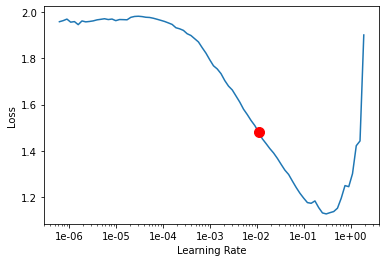

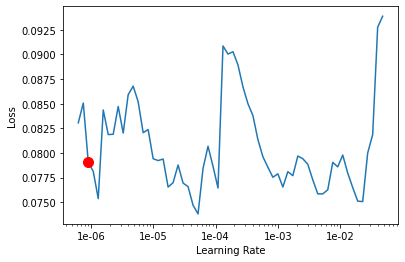

In [ ]:
## 1
train_index, test_index = next(splits)
train_one_split(train_index, test_index)

TRAIN len: 1260 VALID len: 420 TEST len: 420 VALID percent: 20.0 TEST percent: 20.0


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 2.09E-03


epoch,train_loss,valid_loss,accuracy,time
0,0.843655,0.643609,0.926190,03:37
1,0.520296,0.320173,0.933333,03:30


epoch,train_loss,valid_loss,accuracy,time
0,0.358263,0.203221,0.933333,03:37
1,0.279057,0.189382,0.950000,03:53


epoch,train_loss,valid_loss,accuracy,time
0,0.201839,0.189532,0.947619,04:24
1,0.167616,0.168424,0.959524,04:38


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.31E-07


epoch,train_loss,valid_loss,accuracy,time
0,0.120124,0.169182,0.961905,05:10
1,0.124085,0.175687,0.959524,05:02
2,0.118367,0.173972,0.952381,05:13
3,0.122148,0.166877,0.959524,05:00


420
Accuracy: 
0.9571428571428572
[('fe', 'mk'), ('mk', 'rg'), ('hm', 'rn'), ('rn', 'fe'), ('rg', 'rn'), ('mk', 'rg'), ('hm', 'ij'), ('rg', 'mk'), ('rg', 'mk'), ('rg', 'rn'), ('ij', 'rn'), ('ij', 'rn'), ('fe', 'mk'), ('mk', 'rg'), ('rg', 'rn'), ('rg', 'rn'), ('mk', 'fe'), ('ij', 'rg')]
0.9571428571428572 0.9572581941253769


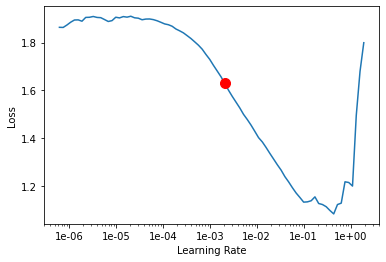

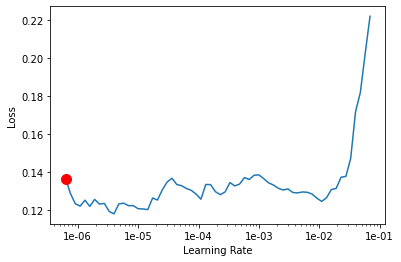

In [ ]:
## 2
train_index, test_index = next(splits)
train_one_split(train_index, test_index)

TRAIN len: 1260 VALID len: 420 TEST len: 420 VALID percent: 20.0 TEST percent: 20.0


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 3.63E-03


epoch,train_loss,valid_loss,accuracy,time
0,0.758491,0.534267,0.935714,03:36
1,0.469069,0.223171,0.957143,03:22


epoch,train_loss,valid_loss,accuracy,time
0,0.300317,0.205449,0.945238,03:39
1,0.231057,0.135094,0.964286,03:54


epoch,train_loss,valid_loss,accuracy,time
0,0.198099,0.127310,0.961905,04:24
1,0.142807,0.113274,0.969048,04:38


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.31E-07


epoch,train_loss,valid_loss,accuracy,time
0,0.095293,0.115770,0.969048,05:14
1,0.109154,0.106025,0.969048,05:01
2,0.100594,0.112324,0.961905,05:13
3,0.097104,0.109192,0.961905,05:11


420
Accuracy: 
0.9523809523809523
[('rg', 'mk'), ('mk', 'ij'), ('mk', 'hm'), ('hm', 'mk'), ('mk', 'hm'), ('fe', 'mk'), ('mk', 'rn'), ('rg', 'ij'), ('hm', 'mk'), ('rg', 'fe'), ('fe', 'mk'), ('fe', 'mk'), ('fe', 'mk'), ('mk', 'rg'), ('ij', 'hm'), ('rg', 'fe'), ('ij', 'rn'), ('ij', 'rn'), ('rg', 'mk'), ('hm', 'mk')]
0.9523809523809523 0.9525624138319404


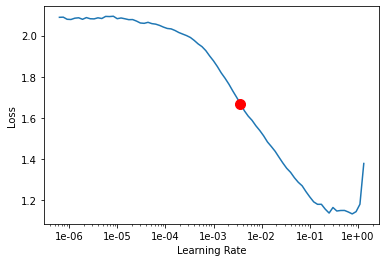

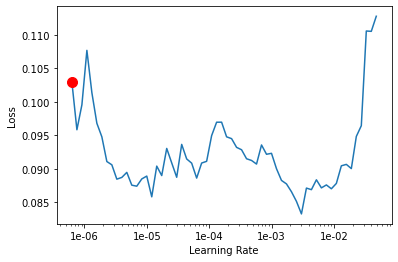

In [ ]:
## 3
train_index, test_index = next(splits)
train_one_split(train_index, test_index)

TRAIN len: 1260 VALID len: 420 TEST len: 420 VALID percent: 20.0 TEST percent: 20.0


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 5.25E-03


epoch,train_loss,valid_loss,accuracy,time
0,0.700560,0.488841,0.916667,03:27
1,0.424732,0.210792,0.952381,03:14


epoch,train_loss,valid_loss,accuracy,time
0,0.299875,0.154863,0.950000,03:37
1,0.223010,0.119681,0.964286,03:50


epoch,train_loss,valid_loss,accuracy,time
0,0.159410,0.102809,0.959524,04:22
1,0.135726,0.122436,0.959524,04:40


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.31E-07


epoch,train_loss,valid_loss,accuracy,time
0,0.092012,0.120142,0.957143,05:29
1,0.098557,0.115316,0.957143,05:12
2,0.088936,0.115228,0.957143,05:04
3,0.087218,0.126583,0.957143,05:40


420
Accuracy: 
0.95
[('mk', 'rg'), ('mk', 'rn'), ('rg', 'rn'), ('mk', 'rn'), ('mk', 'rn'), ('rg', 'fe'), ('mk', 'fe'), ('hm', 'rn'), ('rn', 'fe'), ('fe', 'ij'), ('fe', 'rg'), ('rg', 'rn'), ('mk', 'fe'), ('rn', 'ij'), ('fe', 'ij'), ('hm', 'rn'), ('fe', 'rn'), ('rn', 'ij'), ('hm', 'rg'), ('hm', 'mk'), ('fe', 'mk')]
0.95 0.9500865858071775


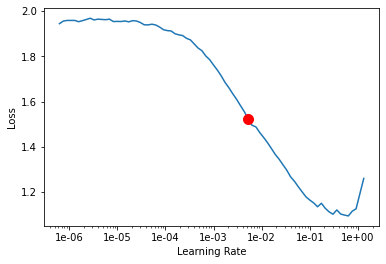

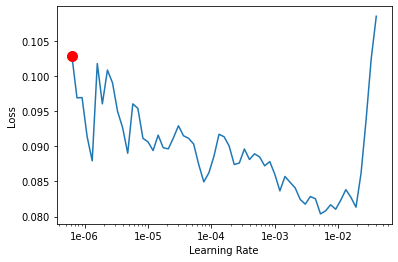

In [ ]:
## 4
train_index, test_index = next(splits)
train_one_split(train_index, test_index)

TRAIN len: 1260 VALID len: 420 TEST len: 420 VALID percent: 20.0 TEST percent: 20.0


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 3.63E-03


epoch,train_loss,valid_loss,accuracy,time
0,0.800734,0.510849,0.926190,03:27
1,0.471605,0.212712,0.969048,03:18


epoch,train_loss,valid_loss,accuracy,time
0,0.266147,0.131767,0.959524,03:46
1,0.220539,0.114767,0.969048,03:42


epoch,train_loss,valid_loss,accuracy,time
0,0.159727,0.144916,0.952381,04:29
1,0.137162,0.110672,0.959524,04:39


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.31E-07


epoch,train_loss,valid_loss,accuracy,time
0,0.093766,0.107785,0.964286,05:17
1,0.096940,0.109550,0.959524,05:09
2,0.107227,0.107373,0.964286,04:57
3,0.101728,0.111482,0.959524,05:05


420
Accuracy: 
0.9452380952380952
[('fe', 'rn'), ('rn', 'ij'), ('hm', 'rn'), ('fe', 'ij'), ('rg', 'mk'), ('rn', 'ij'), ('rn', 'mk'), ('rn', 'ij'), ('rn', 'mk'), ('fe', 'rn'), ('rn', 'rg'), ('rn', 'mk'), ('rg', 'fe'), ('rn', 'ij'), ('rg', 'ij'), ('hm', 'mk'), ('fe', 'mk'), ('rg', 'mk'), ('fe', 'ij'), ('rn', 'mk'), ('rn', 'mk'), ('rn', 'mk'), ('rg', 'rn')]
0.9452380952380952 0.9450340471810388


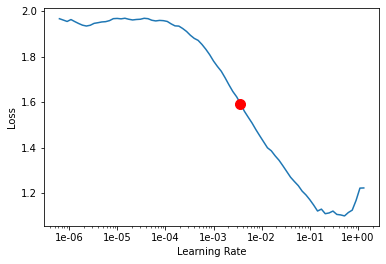

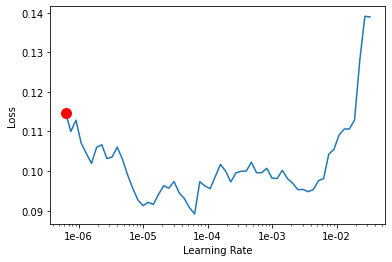

In [33]:
## 5
train_index, test_index = next(splits)
train_one_split(train_index, test_index)

In [1]:
accuracies = [0.95, 0.9571428571428572, 0.9523809523809523, 0.95, 0.9452380952380952 ]
f1_scores = [0.9503410306727527, 0.9572581941253769, 0.9525624138319404, 0.9500865858071775, 0.9450340471810388]

In [4]:
from statistics import mean
mean(accuracies), mean(f1_scores)

(0.9509523809523809, 0.9510564543236573)

In [ ]:
# cm=confusion_matrix(targ, pred)
# df_cm = pd.DataFrame(cm, range(16),range(16))
# plt.figure(figsize = (10,7))
# sn.set(font_scale=1.4)#for label size
# sn.heatmap(df_cm, annot=True,annot_kws={"size": 16},fmt='g',cmap="YlGnBu")# font size

# plt.savefig('news_subword_baad16_cm.eps')
# files.download('news_subword_baad16_cm.eps')